In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## dataset

In [2]:
ratebeer = pd.read_csv("../data/train_ratebeer_without_text.csv")

### 편의점 유통 맥주만 가져오기

In [3]:
kor_beer_list = np.array([ 8666,  75661, 614833, 169964,    251,  10726,   5588,   5571,
                        703,   6668,   7656,   2228, 135361,    473,  36249,    709,
                        12775, 143730,    742,   4007,  72025,  58275, 221535, 291276,
                        2469,   2468, 553454,   1088,    721,  30913,    814,  75071,
                        715,   1267,     55,  17334,     37, 493355,  64253,  34662,
                        136165, 500620,  13833, 506847,  73158,    399,   5159,   3101,
                        315443, 552713, 911382, 906973,    268, 550283, 271470,    390,
                        71469,  35424,   4701,   2514,   2516, 288954,    405, 303473,
                        136785,    647, 632627,   3029,    717, 553245, 580686, 252000,
                        21936, 667837,   2811,    729,  71458, 634182,  86387,   1478,
                        146878, 146725, 149060,  15747, 718172,   3126, 480225, 268685,
                        730, 211962,  64518, 621308,   7580, 452525,   1417,   1486,
                        221])

kor_ratebeer = ratebeer[ratebeer['beer_id'].isin(kor_beer_list)]

In [4]:
# 전체 데이터에서 한국 편의점 맥주 개수
len(kor_ratebeer['beer_name'].unique())

84

### 맥주 점수 분포 체크

In [5]:
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931605 entries, 0 to 2931604
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   review_score  float64
 1   review_time   object 
 2   appearance    float64
 3   aroma         float64
 4   palate        float64
 5   taste         float64
 6   overall       float64
 7   profile_name  object 
 8   beer_name     object 
 9   beer_id       int64  
 10  brewer_id     int64  
 11  abv           float64
 12  style         object 
 13  image_url     object 
 14  user_id       int64  
dtypes: float64(7), int64(3), object(5)
memory usage: 335.5+ MB


In [6]:
ratebeer['review_score'].unique()

array([3.9, 4.1, 3.8, 4. , 4.2, 3.7, 4.5, 4.8, 3.6, 4.7, 4.3, 4.9, 3.4,
       4.4, 5. , 3.5, 4.6, 3.3, 3. , 3.2, 2.9, 3.1, 2.5, 2.4, 2.7, 2.6,
       2.3, 2.8, 1.8, 1.9, 1.5, 1.6, 2.2, 2.1, 2. , 1.4, 1.7, 1.3, 0.9,
       1. , 0.5, 1.2, 1.1, 0.8, 0.6, 0.7])

In [7]:
ratebeer['review_score'].describe()

count    2.931605e+06
mean     3.369230e+00
std      7.281425e-01
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      3.800000e+00
max      5.000000e+00
Name: review_score, dtype: float64

<AxesSubplot:>

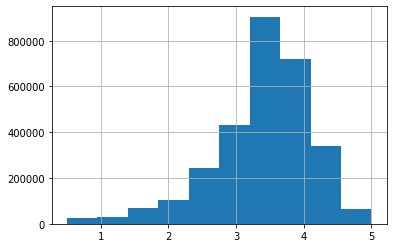

In [8]:
ratebeer['review_score'].hist()

<AxesSubplot:>

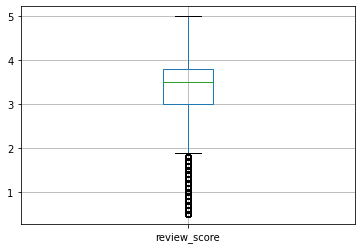

In [9]:
ratebeer[['review_score']].boxplot()

In [10]:
len(ratebeer)

2931605

### preprocessing

In [196]:
def preprocessing_df(df):
    # rating 전처리
    # df['rating/apperance'] = df['review/appearance'].str.split("/").str[0].astype(int)
    # df['rating/aroma'] = df['review/aroma'].str.split("/").str[0].astype(int)
    # df['rating/palate'] = df['review/palate'].str.split("/").str[0].astype(int)
    # df['rating/taste'] = df['review/taste'].str.split("/").str[0].astype(int)
    # df['rating/overall'] = df['review/overall'].str.split("/").str[0].astype(int)
    
    # overall rating 최대치 5로 변환
    # df['rating/overall'] = df['rating/overall'] / 20 * 5
    
    # item, user, rating만 추출
    df = df[['beer_id', 'profile_name', 'review_score', 'image_url']]
    df.rename(columns={'beer_id' : 'item', 'profile_name' : 'user', 'review_score' : 'rating'}, inplace = True) 
    
    # 유저 리뷰 수 개산
    df['user/reviewcount'] = df.groupby('user')['user'].transform('count')
    # 리뷰 수가 10개 이상인 유저만 남김 
    df = df[(df['user/reviewcount'] >= 10)]
    
#     df.drop(columns=['user/reviewcount'], inplace=True)
    
    num_users = df.user.unique().shape[0]
    num_items = df.item.unique().shape[0]
    return df, num_users, num_items

### Statistics of the Dataset

In [197]:
data, num_users, num_items = preprocessing_df(ratebeer)
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 13224, number of items: 9336
matrix sparsity: 0.977028
     item        user  rating  \
0  131594   jmgreenuk     3.9   
1  131594         Ron     3.9   
2  131594     olberic     4.1   
3  131594  bergstaden     4.1   
4  131594      rumore     3.8   

                                           image_url  user/reviewcount  
0  https://res.cloudinary.com/ratebeer/image/uplo...              1299  
1  https://res.cloudinary.com/ratebeer/image/uplo...              1667  
2  https://res.cloudinary.com/ratebeer/image/uplo...               110  
3  https://res.cloudinary.com/ratebeer/image/uplo...               652  
4  https://res.cloudinary.com/ratebeer/image/uplo...               386  


In [198]:
data['rating'].describe()

count    2.836096e+06
mean     3.361636e+00
std      7.133313e-01
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      3.800000e+00
max      5.000000e+00
Name: rating, dtype: float64

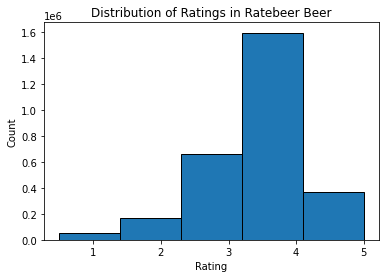

In [199]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Ratebeer Beer')
plt.show()

### Label Encoding

In [200]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user'].values)
data['item_id_idx'] = item_le.fit_transform(data['item'].values)

# data.drop(columns=['user', 'item_id'], inplace=True)

### Loading the data

In [201]:
class BeerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode
        self.train_size = 0.9
        self.val_size = 0.1
        # self.test_size = 1 - self.train_size - self.val_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())
        
        n_val = int(self.num_users * self.val_size)
#         n_test = int(self.num_users * self.test_size)
        
        np.random.seed(42)
        
        val_indices = set(np.random.choice(range(self.num_users), n_val, replace = False))
        # test_indices = set(random.choices(list(set(range(self.num_users)) - val_indices), k=n_test))
        train_indices = set(range(self.num_users)) - val_indices # - test_indices
#         # self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)
        
        if self.mode == 'train':
            self.df = self.df[self.df['user_id_idx'].isin(train_indices)]
        elif self.mode == 'val':
            self.df = self.df[self.df['user_id_idx'].isin(val_indices)]
#         else:
#             self.df = self.df[self.df['user_id_idx'].isin(test_indices)]
        
        # 유저 리뷰 수 개산
        # self.df['user/reviewcount'] = self.df.groupby('user_id_idx')['user_id_idx'].transform('count')
        
        # #리뷰 수가 4개 이상인 유저만 남김 
        # self.df = self.df[(self.df['user/reviewcount'] > 3)]
        # self.df.drop(columns=['user/reviewcount'], inplace=True)
        
        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating
            
        # for user in self.users:
        #     nonzero_ind = np.where(inter_mat[user] > 0)[0]
        #     # if len(nonzero_ind) > 3:
        #     valid_ind = np.random.choice(nonzero_ind, 3, replace = False)
        #     if self.mode == 'train':
        #         inter_mat[user][valid_ind] = 0
        #     else:
        #         inter_mat[user][np.setdiff1d(nonzero_ind, valid_ind)] = 0

        return inter_mat

    def __len__(self):
        # return len(self.users)
        return len(self.inter_mat)

    def __getitem__(self, index):
        # inter_mat = torch.tensor(self.inter_mat[self.users[index]]).float()
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return index, inter_mat

### Autorec Model

In [202]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_items, dropout=0.2):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_items, num_hidden)
        self.activate = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_items)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.activate(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred

###  Model train, validcation

In [203]:
def train(model, train_iter, criterion, optm, device):
    model.train() # to train mode
    loss_sum = 0
    loss_cal_count = 0

    for _, inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss = criterion(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        if not np.isnan(loss.cpu().detach().numpy()):
            loss_cal_count += 1
            loss_sum += loss.item()
            
    # loss_avg = loss_sum / len(train_iter)
    loss_avg = loss_sum / loss_cal_count

    return loss_avg

In [204]:
def validation(model, valid_iter, criterion, device):
    
    # np.random.seed(42)
    
    with torch.no_grad():
        model.eval()
        loss_sum = 0
        loss_cal_count = 0
        
        for _, inter_mat in valid_iter:
            inter_mat = inter_mat.to(device)
            
#             # matrix 값 중 0보다 큰 값만 추출
#             y_for_compute = inter_mat.squeeze().cpu().numpy()
#             index = np.where(y_for_compute > 0)[0]
            
#             # 0보다 큰 값 중 n_val개를 masking
#             n_val = min(int(len(index) * 0.1), 3)
#             valid_ind = np.random.choice(index, n_val, replace = False)
#             y_for_compute[valid_ind] = 0
            
#             # n_val개 masking 된 input 생성
#             masked_input = torch.tensor(y_for_compute).to(device).unsqueeze(0)
            
#             # 정답지는 input에서 masking 되지 않은 위치를 masking  
#             if len(index):
#                 # print(len(index))
#                 # print(valid_ind)
#                 # print(index)
#                 mat_masked_idx = np.array([i for i in index if i not in valid_ind]) 
#                 # print(mat_masked_idx)
#                 inter_mat = inter_mat.squeeze().cpu().numpy()
#                 inter_mat[mat_masked_idx] = 0
#                 inter_mat = torch.tensor(inter_mat).to(device).unsqueeze(0)
            
            # mask된 input으로 prediction 후 기존 정답 활용 loss값 계산
            preds = model(inter_mat)
            loss = criterion(preds, inter_mat)
            
            if not np.isnan(loss.cpu().numpy()):
                loss_cal_count += 1
                loss_sum += loss.item()
            # loss_sum += loss.item()
      
    loss_avg = loss_sum / loss_cal_count
    # loss_avg = loss_sum / len(valid_iter)

        
    return loss_avg

In [205]:
class AutoRec_loss_fn(nn.Module):

    def __init__(self, loss_fn):
        super(AutoRec_loss_fn, self).__init__()
        self.loss_fn = loss_fn
    
    def forward(self, pred, y):
        y_for_compute = y.clone().to('cpu')
        index = np.where(y_for_compute > 0) # FILL HERE : USE np.where & y_for_compute. WARNING: y를 사용 시, y의 device가 gpu일 경우 오류 발생 #
        loss = self.loss_fn(pred[index], y[index])
        return loss

In [206]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 256

PATH = '../model/autorec_exp_rmse.pt'
patience = 5

num_items = data.item_id_idx.nunique()
num_hidden = 500

In [207]:
train_dataset = BeerDataset(df=data, mode='train')
val_dataset = BeerDataset(df=data, mode='val')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

In [208]:
model = AutoRec(num_hidden, num_items).to(device)
loss = AutoRec_loss_fn(nn.MSELoss().to(device)).to(device)
optm = optim.Adam(model.parameters(),lr=lr)

In [209]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

  2%|▎               | 1/50 [00:11<08:59, 11.00s/it]

Validation loss decreased (inf --> 0.673077).  Saving model ...
epoch: 0, train Loss: 1.4742, test Loss: 0.6731


  4%|▋               | 2/50 [00:21<08:40, 10.84s/it]

Validation loss decreased (0.673077 --> 0.567426).  Saving model ...
epoch: 1, train Loss: 0.3205, test Loss: 0.5674


  6%|▉               | 3/50 [00:32<08:18, 10.61s/it]

Validation loss decreased (0.567426 --> 0.492012).  Saving model ...
epoch: 2, train Loss: 0.3102, test Loss: 0.4920


  8%|█▎              | 4/50 [00:42<08:02, 10.50s/it]

Validation loss decreased (0.492012 --> 0.462599).  Saving model ...
epoch: 3, train Loss: 0.3052, test Loss: 0.4626


 10%|█▌              | 5/50 [00:52<07:43, 10.29s/it]

Validation loss decreased (0.462599 --> 0.440095).  Saving model ...
epoch: 4, train Loss: 0.2976, test Loss: 0.4401


 12%|█▉              | 6/50 [01:02<07:31, 10.26s/it]

Validation loss decreased (0.440095 --> 0.419440).  Saving model ...
epoch: 5, train Loss: 0.2924, test Loss: 0.4194


 14%|██▏             | 7/50 [01:13<07:29, 10.44s/it]

Validation loss decreased (0.419440 --> 0.412163).  Saving model ...
epoch: 6, train Loss: 0.2861, test Loss: 0.4122


 16%|██▌             | 8/50 [01:24<07:24, 10.58s/it]

Validation loss decreased (0.412163 --> 0.398029).  Saving model ...
epoch: 7, train Loss: 0.2811, test Loss: 0.3980


 18%|██▉             | 9/50 [01:34<07:12, 10.55s/it]

Validation loss decreased (0.398029 --> 0.393607).  Saving model ...
epoch: 8, train Loss: 0.2750, test Loss: 0.3936
Validation loss decreased (0.393607 --> 0.387174).  Saving model ...


 20%|███            | 10/50 [01:44<06:57, 10.43s/it]

epoch: 9, train Loss: 0.2712, test Loss: 0.3872


 22%|███▎           | 11/50 [01:55<06:46, 10.42s/it]

Validation loss decreased (0.387174 --> 0.381748).  Saving model ...
epoch: 10, train Loss: 0.2645, test Loss: 0.3817


 24%|███▌           | 12/50 [02:05<06:33, 10.34s/it]

Validation loss decreased (0.381748 --> 0.377117).  Saving model ...
epoch: 11, train Loss: 0.2585, test Loss: 0.3771


 26%|███▉           | 13/50 [02:15<06:20, 10.29s/it]

Validation loss decreased (0.377117 --> 0.376540).  Saving model ...
epoch: 12, train Loss: 0.2539, test Loss: 0.3765


 28%|████▏          | 14/50 [02:25<06:09, 10.28s/it]

Validation loss decreased (0.376540 --> 0.372818).  Saving model ...
epoch: 13, train Loss: 0.2476, test Loss: 0.3728


 30%|████▌          | 15/50 [02:36<06:05, 10.44s/it]

Validation loss decreased (0.372818 --> 0.369381).  Saving model ...
epoch: 14, train Loss: 0.2427, test Loss: 0.3694


 32%|████▊          | 16/50 [02:46<05:52, 10.36s/it]

Validation loss decreased (0.369381 --> 0.368429).  Saving model ...
epoch: 15, train Loss: 0.2371, test Loss: 0.3684


 34%|█████          | 17/50 [02:57<05:40, 10.31s/it]

Validation loss decreased (0.368429 --> 0.365512).  Saving model ...
epoch: 16, train Loss: 0.2331, test Loss: 0.3655


 36%|█████▍         | 18/50 [03:07<05:30, 10.34s/it]

Validation loss decreased (0.365512 --> 0.364844).  Saving model ...
epoch: 17, train Loss: 0.2282, test Loss: 0.3648


 38%|█████▋         | 19/50 [03:17<05:22, 10.39s/it]

Validation loss decreased (0.364844 --> 0.364042).  Saving model ...
epoch: 18, train Loss: 0.2233, test Loss: 0.3640


 40%|██████         | 20/50 [03:28<05:11, 10.38s/it]

Validation loss decreased (0.364042 --> 0.362834).  Saving model ...
epoch: 19, train Loss: 0.2182, test Loss: 0.3628


 42%|██████▎        | 21/50 [03:38<04:58, 10.30s/it]

EarlyStopping counter: 1 out of 5
epoch: 20, train Loss: 0.2164, test Loss: 0.3630


 44%|██████▌        | 22/50 [03:48<04:47, 10.27s/it]

Validation loss decreased (0.362834 --> 0.358615).  Saving model ...
epoch: 21, train Loss: 0.2114, test Loss: 0.3586


 46%|██████▉        | 23/50 [03:59<04:41, 10.43s/it]

Validation loss decreased (0.358615 --> 0.356676).  Saving model ...
epoch: 22, train Loss: 0.2083, test Loss: 0.3567


 48%|███████▏       | 24/50 [04:10<04:32, 10.50s/it]

EarlyStopping counter: 1 out of 5
epoch: 23, train Loss: 0.2046, test Loss: 0.3592


 50%|███████▌       | 25/50 [04:20<04:23, 10.55s/it]

EarlyStopping counter: 2 out of 5
epoch: 24, train Loss: 0.2021, test Loss: 0.3571


 52%|███████▊       | 26/50 [04:31<04:15, 10.64s/it]

Validation loss decreased (0.356676 --> 0.354922).  Saving model ...
epoch: 25, train Loss: 0.1979, test Loss: 0.3549


 54%|████████       | 27/50 [04:41<04:03, 10.57s/it]

EarlyStopping counter: 1 out of 5
epoch: 26, train Loss: 0.1952, test Loss: 0.3567


 56%|████████▍      | 28/50 [04:52<03:52, 10.56s/it]

Validation loss decreased (0.354922 --> 0.353712).  Saving model ...
epoch: 27, train Loss: 0.1921, test Loss: 0.3537


 58%|████████▋      | 29/50 [05:02<03:38, 10.39s/it]

EarlyStopping counter: 1 out of 5
epoch: 28, train Loss: 0.1897, test Loss: 0.3544


 60%|█████████      | 30/50 [05:12<03:25, 10.29s/it]

Validation loss decreased (0.353712 --> 0.353352).  Saving model ...
epoch: 29, train Loss: 0.1869, test Loss: 0.3534


 62%|█████████▎     | 31/50 [05:23<03:16, 10.34s/it]

Validation loss decreased (0.353352 --> 0.351217).  Saving model ...
epoch: 30, train Loss: 0.1837, test Loss: 0.3512


 64%|█████████▌     | 32/50 [05:33<03:07, 10.44s/it]

EarlyStopping counter: 1 out of 5
epoch: 31, train Loss: 0.1811, test Loss: 0.3534


 66%|█████████▉     | 33/50 [05:44<02:58, 10.51s/it]

EarlyStopping counter: 2 out of 5
epoch: 32, train Loss: 0.1794, test Loss: 0.3563


 68%|██████████▏    | 34/50 [05:55<02:52, 10.78s/it]

Validation loss decreased (0.351217 --> 0.351082).  Saving model ...
epoch: 33, train Loss: 0.1770, test Loss: 0.3511


 70%|██████████▌    | 35/50 [06:06<02:41, 10.75s/it]

EarlyStopping counter: 1 out of 5
epoch: 34, train Loss: 0.1753, test Loss: 0.3514


 72%|██████████▊    | 36/50 [06:17<02:30, 10.77s/it]

Validation loss decreased (0.351082 --> 0.350255).  Saving model ...
epoch: 35, train Loss: 0.1734, test Loss: 0.3503


 74%|███████████    | 37/50 [06:27<02:18, 10.67s/it]

Validation loss decreased (0.350255 --> 0.349764).  Saving model ...
epoch: 36, train Loss: 0.1702, test Loss: 0.3498


 76%|███████████▍   | 38/50 [06:38<02:07, 10.60s/it]

EarlyStopping counter: 1 out of 5
epoch: 37, train Loss: 0.1698, test Loss: 0.3506


 78%|███████████▋   | 39/50 [06:48<01:56, 10.62s/it]

EarlyStopping counter: 2 out of 5
epoch: 38, train Loss: 0.1669, test Loss: 0.3499


 80%|████████████   | 40/50 [06:59<01:46, 10.69s/it]

Validation loss decreased (0.349764 --> 0.348454).  Saving model ...
epoch: 39, train Loss: 0.1645, test Loss: 0.3485


 82%|████████████▎  | 41/50 [07:09<01:34, 10.48s/it]

EarlyStopping counter: 1 out of 5
epoch: 40, train Loss: 0.1640, test Loss: 0.3485


 84%|████████████▌  | 42/50 [07:19<01:22, 10.35s/it]

Validation loss decreased (0.348454 --> 0.348284).  Saving model ...
epoch: 41, train Loss: 0.1614, test Loss: 0.3483


 86%|████████████▉  | 43/50 [07:30<01:13, 10.47s/it]

Validation loss decreased (0.348284 --> 0.347898).  Saving model ...
epoch: 42, train Loss: 0.1608, test Loss: 0.3479


 88%|█████████████▏ | 44/50 [07:40<01:02, 10.36s/it]

Validation loss decreased (0.347898 --> 0.347755).  Saving model ...
epoch: 43, train Loss: 0.1584, test Loss: 0.3478


 90%|█████████████▌ | 45/50 [07:50<00:51, 10.32s/it]

EarlyStopping counter: 1 out of 5
epoch: 44, train Loss: 0.1572, test Loss: 0.3484


 92%|█████████████▊ | 46/50 [08:01<00:41, 10.49s/it]

Validation loss decreased (0.347755 --> 0.345889).  Saving model ...
epoch: 45, train Loss: 0.1555, test Loss: 0.3459


 94%|██████████████ | 47/50 [08:11<00:31, 10.41s/it]

EarlyStopping counter: 1 out of 5
epoch: 46, train Loss: 0.1534, test Loss: 0.3464


 96%|██████████████▍| 48/50 [08:21<00:20, 10.28s/it]

EarlyStopping counter: 2 out of 5
epoch: 47, train Loss: 0.1512, test Loss: 0.3473


 98%|██████████████▋| 49/50 [08:32<00:10, 10.39s/it]

EarlyStopping counter: 3 out of 5
epoch: 48, train Loss: 0.1507, test Loss: 0.3487


100%|███████████████| 50/50 [08:42<00:00, 10.46s/it]

EarlyStopping counter: 4 out of 5
epoch: 49, train Loss: 0.1500, test Loss: 0.3465


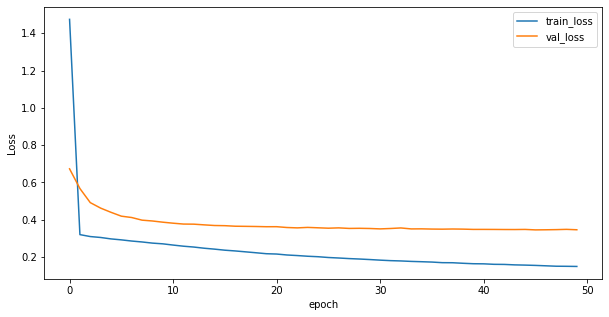

In [210]:
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience = patience, verbose = True, path=PATH)

for epoch in tqdm(range(num_epochs)):

    train_loss = train(model, train_dataloader, loss, optm, device)
    val_loss = validation(model, val_dataloader, loss, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## inference

### 모델 불러오기

In [211]:
model = AutoRec(num_hidden, num_items).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 파일 불러오기

In [212]:
test_input = pd.read_csv("../data/test_input_ratebeer_without_text_limit30.csv")
test_ans = pd.read_csv("../data/test_output_ratebeer_without_text_limit30.csv")

In [213]:
test_input.head()

,user_id,beer_id,review_score,review_time,appearance,aroma,palate,taste,overall,profile_name,beer_name,brewer_id,abv,style,image_url
0,4,145903,4.2,2021-08-19 22:01:20.193000+00:00,4.0,9.0,4.0,8.0,17.0,ZayZay,Hill Farmstead Double Citra,11233,8.0,IIPA DIPA - Imperial / Double Hazy (NEIPA),https://res.cloudinary.com/ratebeer/image/uplo...
1,4,114499,3.9,2021-01-25 03:00:13.110000+00:00,3.0,8.0,4.0,8.0,16.0,ZayZay,St-Ambroise Stout Impériale Russe,137,9.2,Stout - Imperial,https://res.cloudinary.com/ratebeer/image/uplo...
2,4,12027,3.8,2021-08-23 02:21:37.730000+00:00,4.0,8.0,4.0,7.0,15.0,ZayZay,Boon Oude Geuze Mariage Parfait,748,8.0,Lambic - Gueuze,https://res.cloudinary.com/ratebeer/image/uplo...
3,4,1921,3.4,2021-03-14 01:55:44.420000+00:00,3.0,7.0,3.0,7.0,14.0,ZayZay,Unibroue Maudite,180,8.0,Dubbel,https://res.cloudinary.com/ratebeer/image/uplo...
4,4,15121,3.9,2020-12-07 03:36:06.880000+00:00,3.0,8.0,4.0,8.0,16.0,ZayZay,Dieu du Ciel! Solstice d'Hiver,364,10.2,Barley Wine / Wheat Wine / Rye Wine,https://res.cloudinary.com/ratebeer/image/uplo...


In [214]:
test_ans.head()

,user_id,beer_id,review_score,review_time,appearance,aroma,palate,taste,overall,profile_name,beer_name,brewer_id,abv,style,image_url
0,4,37,1.9,2021-07-08 03:31:02.923000+00:00,3.0,3.0,2.0,3.0,8.0,ZayZay,Heineken,9,5.0,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
1,4,709,1.6,2021-01-11 01:47:51.440000+00:00,2.0,3.0,1.0,3.0,7.0,ZayZay,Carlsberg Pilsner,43,4.6,Pilsener / Pils / Pilsner,https://res.cloudinary.com/ratebeer/image/uplo...
2,4,473,1.7,2022-05-27 03:50:49.850000+00:00,3.0,3.0,2.0,3.0,6.0,ZayZay,Budweiser,84,5.0,Pale Lager - American,https://res.cloudinary.com/ratebeer/image/uplo...
3,4,742,1.7,2020-10-24 21:25:51.827000+00:00,2.0,3.0,2.0,3.0,7.0,ZayZay,Corona Extra,119,4.5,Pale Lager - American,https://res.cloudinary.com/ratebeer/image/uplo...
4,6,1478,2.0,2010-12-29 10:07:17.433000+00:00,1.0,4.0,2.0,5.0,8.0,PapaSkeetSkeet,Stella Artois,260,5.2,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...


### labelEncoding

In [215]:
user_test_le = LabelEncoder()

test_input['user_id_idx'] = user_test_le.fit_transform(test_input['profile_name'].values)
test_input['item_id_idx'] = item_le.transform(test_input['beer_id'].values)

test_ans['user_id_idx'] = user_test_le.transform(test_ans['profile_name'].values)
test_ans['item_id_idx'] = item_le.transform(test_ans['beer_id'].values)


In [216]:
class TestBeerDataset(Dataset):
    def __init__(self, input_df, ans_df):
        self.input_df = input_df
        self.ans_df = ans_df

        self.num_items = self.ans_df.item_id_idx.max() + 1
        self.num_users = self.ans_df.user_id_idx.nunique()
        
        # input matrix
        self.users = torch.tensor(self.input_df['user_id_idx'].values)
        self.items = torch.tensor(self.input_df['item_id_idx'].values)
        self.ratings = torch.tensor(self.input_df['review_score'].values)
        
        self.inter_mat_input = self.make_inter_mat()
        
        # ans matrix
        self.users = torch.tensor(self.ans_df['user_id_idx'].values)
        self.items = torch.tensor(self.ans_df['item_id_idx'].values)
        self.ratings = torch.tensor(self.ans_df['review_score'].values)
        
        self.inter_mat_ans = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating

        return inter_mat

    def __len__(self):
        # return len(self.users)
        return len(self.inter_mat_input)

    def __getitem__(self, index):
        # inter_mat = torch.tensor(self.inter_mat[self.users[index]]).float()
        inter_mat_input = torch.tensor(self.inter_mat_input[index]).float()
        inter_mat_ans = torch.tensor(self.inter_mat_ans[index]).float()

        return index, inter_mat_input, inter_mat_ans

### 평가지표 함수

In [217]:
def ndcg_k(actual, predicted, topk):
    res = 0
    for user_id in range(len(actual)):
        k = min(topk, len(actual[user_id]))
        idcg = idcg_k(k)
        dcg_k = sum(
            [
                int(predicted[user_id][j] in set(actual[user_id])) / math.log(j + 2, 2)
                for j in range(topk)
            ]
        )
        res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k(actual, predicted, topk):
    sum_recall = 0.0
    num_users = len(predicted)
    true_users = 0
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        if len(act_set) != 0:
            sum_recall += len(act_set & pred_set) / float(len(act_set))
            true_users += 1
    return sum_recall / true_users

In [218]:
def inference(model, test_iter, criterion, device):
    
    # np.random.seed(42)
    
    with torch.no_grad():
        model.eval()
        loss_sum = 0
        loss_cal_count = 0
        
        for _, inter_mat_input, inter_mat_ans in test_iter:
            inter_mat_input = inter_mat_input.to(device)
            inter_mat_ans = inter_mat_ans.to(device)
            
#             # matrix 값 중 0보다 큰 값만 추출
#             y_for_compute = inter_mat.squeeze().cpu().numpy()
#             index = np.where(y_for_compute > 0)[0]
            
#             # 0보다 큰 값 중 n_val개를 masking
#             n_val = min(int(len(index) * 0.1), 3)
#             valid_ind = np.random.choice(index, n_val, replace = False)
#             y_for_compute[valid_ind] = 0
            
#             # n_val개 masking 된 input 생성
#             masked_input = torch.tensor(y_for_compute).to(device).unsqueeze(0)
            
#             # 정답지는 input에서 masking 되지 않은 위치를 masking  
#             if len(index):
#                 # print(len(index))
#                 # print(valid_ind)
#                 # print(index)
#                 mat_masked_idx = np.array([i for i in index if i not in valid_ind]) 
#                 # print(mat_masked_idx)
#                 inter_mat = inter_mat.squeeze().cpu().numpy()
#                 inter_mat[mat_masked_idx] = 0
#                 inter_mat = torch.tensor(inter_mat).to(device).unsqueeze(0)
            
            # mask된 input으로 prediction 후 기존 정답 활용 loss값 계산
            preds = model(inter_mat_input)
            loss = criterion(preds, inter_mat_ans)
            
            if not np.isnan(loss.cpu().numpy()):
                loss_cal_count += 1
                loss_sum += loss.item()
            
        loss_avg = loss_sum / loss_cal_count
        print(f'test mse = {loss_avg}')
        print(f'test rmse = {loss_avg ** (1/2)}')
    return loss_avg

In [74]:
# def inference(model, test_iter, test_matrix, device, topk = 4):
#     pred_list = None
#     answer_list = None
#     with torch.no_grad():
#         model.eval()

#         for i, (user_ids, inter_mat) in enumerate(test_iter):
#             inter_mat = inter_mat.to(device)
            
#             rating_pred = model(inter_mat)
            
#             rating_pred = rating_pred.cpu().data.numpy().copy()
            
#             batch_user_index = user_ids.cpu().numpy()
#             answers = test_matrix.argsort(axis = 1)[batch_user_index, -topk:][:, ::-1]
#             # rating_pred[test_matrix[batch_user_index] > 0] = 0
            
#             ind = np.argpartition(rating_pred, -topk)[:, -topk:]
            
#             arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]

#             arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]

#             batch_pred_list = ind[
#                 np.arange(len(rating_pred))[:, None], arr_ind_argsort
#             ]

#             if i == 0:
#                 pred_list = batch_pred_list
#                 answer_list = answers
#             else:
#                 pred_list = np.append(pred_list, batch_pred_list, axis=0)
#                 answer_list = np.append(
#                         answer_list, answers, axis=0
#                 )
            
#         recall = recall_at_k(answer_list, pred_list, topk)
#         ndcg = ndcg_k(answer_list, pred_list, topk)
        
#         print(f'recall@{topk} = {recall}, ndcg@{topk} = {ndcg}')
#     return pred_list, answer_list

In [219]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 1

num_items = data.item_id_idx.nunique()
num_hidden = 500

In [220]:
test_dataset = TestBeerDataset(input_df = test_input, ans_df = test_ans)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# test_matrix = test_dataset.inter_mat
loss = AutoRec_loss_fn(nn.MSELoss().to(device)).to(device)

### inference 수행

In [221]:
# pred_list, answer_list = inference(model, test_dataloader, test_matrix, device, topk=4)
# model, test_iter, criterion, device
mse = inference(model, test_dataloader, loss, device)

test mse = 0.6469916865955239
test rmse = 0.8043579343771801


### 웹사이트 inference

In [95]:
kor_beer_list = np.array([ 8666,  75661, 614833, 169964,    251,  10726,   5588,   5571,
                        703,   6668,   7656,   2228, 135361,    473,  36249,    709,
                        12775, 143730,    742,   4007,  72025,  58275, 221535, 291276,
                        2469,   2468, 553454,   1088,    721,  30913,    814,  75071,
                        715,   1267,     55,  17334,     37, 493355,  64253,  34662,
                        136165, 500620,  13833, 506847,  73158,    399,   5159,   3101,
                        315443, 552713, 911382, 906973,    268, 550283, 271470,    390,
                        71469,  35424,   4701,   2514,   2516, 288954,    405, 303473,
                        136785,    647, 632627,   3029,    717, 553245, 580686, 252000,
                        21936, 667837,   2811,    729,  71458, 634182,  86387,   1478,
                        146878, 146725, 149060,  15747, 718172,   3126, 480225, 268685,
                        730, 211962,  64518, 621308,   7580, 452525,   1417,   1486,
                        221])

kor_ratebeer = ratebeer[ratebeer['beer_id'].isin(kor_beer_list)]

In [96]:
kor_ratebeer['review_score'].describe()

count    89498.000000
mean         2.760370
std          0.944286
min          0.500000
25%          2.100000
50%          2.900000
75%          3.500000
max          5.000000
Name: review_score, dtype: float64

In [97]:
kor_beer_idx = data[data['item'].isin(kor_beer_list)]['item_id_idx'].unique()

In [98]:
# 웹사이트 input
# x_test = torch.tensor([1.9, 0. , 0. , 1.5, 2.2, 2.1, 3.5, 1.9, 1.4, 3.4, 2.8, 0. , 0. ,
#        3.3, 0. , 3.6, 1.7, 1.6, 3.5, 3.8, 2.8, 2.2, 0. , 2.9, 3. , 3. ,
#        3.4, 3.3, 0. , 0. , 2. , 2.4, 0. , 1.8, 0. , 2.3, 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.2, 0. , 0. , 0. , 0. , 3. ,
#        3.1, 0. , 1.9, 3.7, 2. , 0. , 3.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 3. , 1.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. ]).to(device)

num_item = data['item'].nunique()

# 한국 맥주 평가
rating_list = [5.0, 2.76, 0.5] # 좋아요, 몰라요, 싫어요
kor_beer_idx = data[data['item'].isin(kor_beer_list)]['item_id_idx'].unique()
show_list = np.random.choice(kor_beer_idx, 29, replace=False) # 임의로 29개 추출
not_show_list = set(kor_beer_idx) - set(show_list)
x_test = torch.zeros(num_item).to(device) # 0으로 초기화

for beer in show_list:
    x_test[beer] = random.choice(rating_list) # 29개에 대해서 임의로 평가
    
# for beer in not_show_list:
#     x_test[beer] = rating_list[1] # 나머지는 몰라요로 배정
    
# show_df = data[data['item_id_idx'].isin(show_list)]

# 나머지 맥주 중 일부 평가
not_kor_rating_list = [5.0, 3.36, 0.5]
not_kor_idx = np.delete(np.arange(num_item), kor_beer_idx)
not_kor_choice = np.random.randint(int(len(not_kor_idx) * 0.3))
not_kor_list = np.random.choice(not_kor_idx, not_kor_choice , replace=False) 

for beer in not_kor_list:
    x_test[beer] = random.choice(not_kor_rating_list)

# for i in not_show_list:
#     style = data[data['item_id_idx'] == i]['label'].unique()[0]
#     rating = show_df[show_df['label'] == style]['rating'].mean()
    
#     if np.isnan(rating):
#         rating = rating_list[1] # style로 점수를 채울 수 없는 경우 몰라요로 채운다
#     x_test[i] = rating
#     # print(rating)

# 추천 맥주 개수
topk = 4

# 모델 에측 맥주 평점
rating_pred = model(x_test)

rating_pred = rating_pred.cpu().data.numpy().copy()
# print(rating_pred)

rating_pred = rating_pred[kor_beer_idx]
x_test = x_test[kor_beer_idx]
# batch_user_index = user_ids.cpu().numpy()


answers = x_test.cpu().numpy().argsort()[-topk:][::-1]
# print(answers)

# user가 리뷰를 남긴 맥주 추천하고 싶지 않을 때 사용

# if novelty:
# 좋아요, 싫어요로 직접 평가한 맥주는 다시 추천하지 않도록 설정
rating_pred[x_test.cpu().numpy() == rating_list[0]] = 0
rating_pred[x_test.cpu().numpy() == rating_list[2]] = 0
# print(rating_pred)

# topk 맥주 index
ind = np.argpartition(rating_pred, -topk)[-topk:]
# print(ind)

# topk 맥주 index별 평점
arr_ind = rating_pred[ind]
# print(arr_ind)

# 평점 기준으로 내림차순으로 정렬
arr_ind_argsort = np.argsort(arr_ind)[::-1]
# print(arr_ind_argsort)

# rating 내림차순 모델 예측 topk 맥주 index 
topk_pred_list = ind[arr_ind_argsort]
print(topk_pred_list)

# rating 내림차순 모델 예측 맥주 평점 중 topk개
topk_rating_list = rating_pred[topk_pred_list] #rating_pred[np.arange(len(rating_pred))[:, None], ind]
print(topk_rating_list)

[ 6 30 38 18]
[3.5747483 3.5603347 3.5262082 3.515745 ]


In [99]:
# 모델 예측 선호 맥주 top4
topk_pred_list

array([ 6, 30, 38, 18])

In [100]:
# 유저 실제 선호 맥주 top4
answers

array([41, 68, 47, 60])

In [101]:
rating_pred[topk_pred_list]

array([3.5747483, 3.5603347, 3.5262082, 3.515745 ], dtype=float32)

In [102]:
label_list = ['good', 'unknown', 'bad']

for i, rating in enumerate(rating_list):
    print(label_list[i])
    print(list(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True)))
    print()

good
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

unknown
[3.5747483, 3.446067, 3.1368904, 2.8892136, 2.6785285, 2.3906837, 2.339925, 2.121801, 2.1044433, 1.7575008, 1.283271]

bad
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



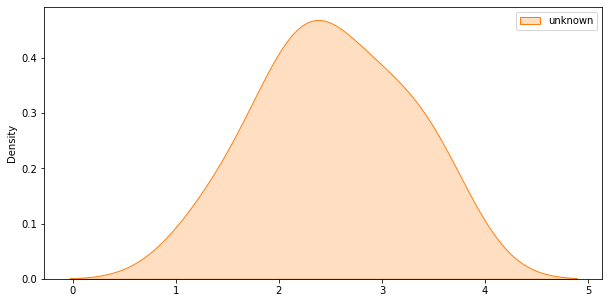

In [103]:
label_list = ['good', 'unknown', 'bad']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, rating in enumerate(rating_list):
    
    ax = sns.kdeplot(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True), label = label_list[i], fill = True)

plt.legend()
plt.show()

<AxesSubplot:ylabel='Count'>

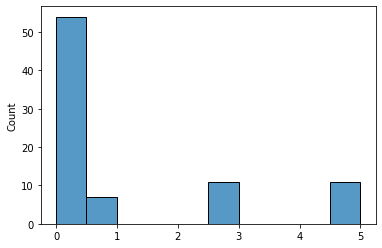

In [104]:
sns.histplot(x_test.cpu().numpy(), bins = 10)

<AxesSubplot:ylabel='Count'>

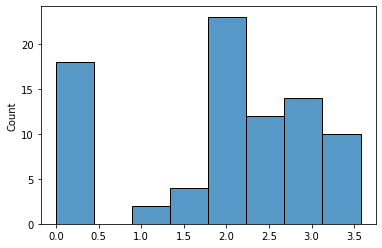

In [105]:
sns.histplot(rating_pred)

In [106]:
# 모델 예측 rating 점수
rating_pred

array([0.       , 3.0525815, 2.1359549, 0.       , 0.       , 3.3736598,
       3.5747483, 1.283271 , 1.3689643, 0.       , 2.1895251, 0.       ,
       2.4341   , 3.2824535, 2.6885073, 2.1821036, 2.0650685, 1.7575008,
       3.515745 , 0.       , 0.       , 2.6815033, 0.       , 1.9632633,
       2.1076906, 2.5430439, 2.8551211, 2.9747274, 3.2163415, 3.446067 ,
       3.5603347, 2.7279627, 2.1786199, 2.121801 , 2.1733181, 2.1366975,
       2.316389 , 1.5921401, 3.5262082, 2.0822532, 1.9622264, 0.       ,
       1.8492153, 2.8516736, 2.8767123, 2.8892136, 3.1368904, 0.       ,
       2.7505822, 2.1044433, 2.4846385, 2.1309643, 0.       , 3.138443 ,
       2.339925 , 2.5860083, 1.7392612, 0.       , 2.3166032, 1.9333149,
       0.       , 2.07833  , 2.7070012, 2.4165595, 1.9827561, 0.       ,
       2.8615506, 2.6785285, 0.       , 2.776503 , 1.9981554, 2.9562573,
       2.3906837, 2.193016 , 0.       , 1.3377304, 2.1185236, 0.       ,
       0.       , 2.6080594, 1.8587161, 1.9599879, 

In [107]:
x_test

tensor([0.5000, 0.0000, 0.0000, 0.5000, 5.0000, 0.0000, 2.7600, 2.7600, 0.0000,
        0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7600,
        0.0000, 0.5000, 5.0000, 0.0000, 5.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 2.7600, 0.0000, 0.0000, 0.0000, 2.7600, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000, 0.0000,
        2.7600, 2.7600, 5.0000, 0.0000, 2.7600, 0.0000, 0.0000, 5.0000, 0.0000,
        2.7600, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 5.0000, 0.0000, 2.7600, 5.0000, 0.0000, 0.0000, 0.0000,
        2.7600, 0.0000, 0.5000, 0.0000, 0.0000, 5.0000, 5.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')

In [108]:
kor_beer_idx

array([  23,   37,  132,  148,  159,  201,  205,  210,  258,  364,  405,
        410,  414,  415,  417,  419,  420,  432,  450,  553,  673, 6651,
        692,  695, 9329, 4851,  866,  981,  982, 1001, 1003, 4887, 1078,
       1128, 1144, 1147, 4925, 1339, 9039, 1503, 1612, 1697, 1705, 9073,
       6653, 9319, 6687, 9323, 1945, 2170, 6741, 2186,  612, 6814, 9334,
       6836, 2835, 9335, 6283, 9330, 9320, 9235, 3546, 9238, 3722, 9254,
       4665, 9326, 7342, 9328, 4051, 9322, 9321, 9332, 6012, 9327, 9324,
       9331, 9325, 9333, 6277, 3338, 2422])

In [109]:
# image url
data[data['item_id_idx'].isin(kor_beer_idx[topk_pred_list])]['image_url'].unique()

array(['https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_399',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_814',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_2516',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_135361'],
      dtype=object)

In [110]:
# 맥주 이름
data[data['item_id_idx'].isin(kor_beer_idx[topk_pred_list])]['item'].unique()

array([   399,    814,   2516, 135361])

### 평가지표 점수

In [141]:
def ndcg_k_inf(actual, predicted, topk):
    res = 0
    k = min(topk, len(actual))
    idcg = idcg_k(k)
    dcg_k = sum(
        [
            int(predicted[j] in set(actual)) / math.log(j + 2, 2)
            for j in range(topk)
        ]
    )
    res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k_inf(actual, predicted, topk):
    act_set = set(actual)
    pred_set = set(predicted[:topk])
    if len(act_set) != 0:
        sum_recall = len(act_set & pred_set) / float(len(act_set))
        
    return sum_recall

In [142]:
recall_at_k_inf(answers, topk_pred_list, 4)

0.0

In [143]:
ndcg_k_inf(answers, topk_pred_list, 4)

0.0

In [144]:
data

,item,user,rating,imageUrl,user/reviewcount,user_id_idx,item_id_idx
0,75661,Grzesiek79,1.3,https://res.cloudinary.com/ratebeer/image/uplo...,55,3051,56
1,75661,GriZZZly,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,13,3028,56
2,75661,bdleedahl,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,31,8450,56
3,75661,DoctorHU,2.6,https://res.cloudinary.com/ratebeer/image/uplo...,48,2153,56
4,75661,McTapps,2.5,https://res.cloudinary.com/ratebeer/image/uplo...,49,4783,56
...,...,...,...,...,...,...,...
93615,703,Bov,3.0,https://res.cloudinary.com/ratebeer/image/uplo...,46,1215,10
93616,703,sallyclub99,4.2,https://res.cloudinary.com/ratebeer/image/uplo...,7,15196,10
93617,703,kublai3,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,6,12689,10
93618,703,Aubrey,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,23,520,10


In [40]:
data.to_csv('../data/ratebeer_label_encoding.csv', index = False)

### 리뷰 수 별 loss값 비교

In [ ]:
train Loss: 0.1429, test Loss: 0.3887, test rmse = 0.9741268377904415
train Loss: 0.1597, test Loss: 0.3982, test rmse = 0.9178506077363462
train Loss: 0.1498, test Loss: 0.3815, test rmse = 0.9185960203148705
train Loss: 0.1526, test Loss: 0.3700, test rmse = 0.8679648307799166
train Loss: 0.1647, test Loss: 0.3780, test rmse = 0.78464359338185
train Loss: 0.1535, test Loss: 0.3589, test rmse = 0.8115433694417444
train Loss: 0.1555, test Loss: 0.3459, test rmse = 0.8043579343771801

In [222]:
train_loss_list = [0.1429, 0.1597, 0.1498, 0.1526, 0.1647, 0.1535, 0.1555]
valid_loss_list = [0.3887, 0.3982, 0.3815, 0.3700, 0.3780, 0.3589, 0.3459]
test_loss_list = [0.9741, 0.9179, 0.9186, 0.8680, 0.7846, 0.8115, 0.8044]
review_n = [i for i in range(4, 11)]

In [224]:
train_loss_list = [i ** (1/2) for i in train_loss_list]
valid_loss_list = [i ** (1/2) for i in valid_loss_list]

In [228]:
train_loss_list

[0.378021163428716,
 0.3996248240537617,
 0.38704004960727256,
 0.3906404996924922,
 0.4058324777540605,
 0.39179076048319467,
 0.39433488306260706]

In [227]:
valid_loss_list

[0.6234580980306536,
 0.63103090257134,
 0.6176568626672904,
 0.6082762530298219,
 0.6148170459575759,
 0.5990826320300063,
 0.5881326381013045]

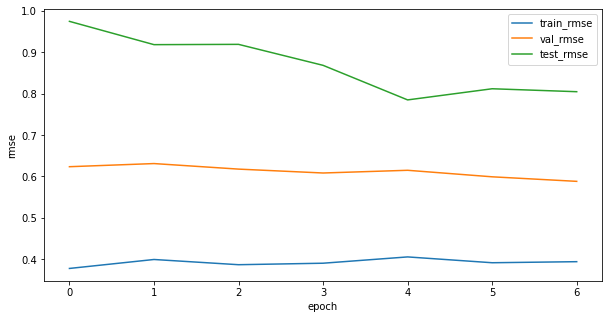

In [226]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_list,label="train_rmse")
plt.plot(valid_loss_list,label="val_rmse")
plt.plot(test_loss_list,label="test_rmse")
plt.xlabel("epoch")
plt.ylabel("rmse")
plt.legend()
plt.show()